In [18]:
# import libraries
from numpy import mean
from numpy import std
from numpy import hstack
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
import copy

# reading csv files
df =  pd.read_csv('adult.data', sep=",", header=None, skipinitialspace=True)
df2 = pd.read_csv('adult.test', sep=",", header=None, skipinitialspace=True)

# Join the data and test files together
df = pd.concat([df, df2])

# Shuffle the rows
df = df.sample(frac=1).reset_index(drop=True)

# Replace all of ? with None
df = df.replace(['?'], [None])
# Drop all rows with None in them
df = df.dropna(axis=0)

# Check no None values remain
df.isnull().sum()

#Adding column headers to our data 
df.columns = ["Age", "Workclass", "Fnlwgt", "Education", "Education-num", "Marital-status", "Occupation", "Relationship", "Race", "Sex", "Capital-gain", "Capital-loss", "Hours-per-week", "Native-country", "Income"]


#Since data prep is slightly different for our LR code, need a copy of the dataset 
data = copy.deepcopy(df)

# Workclass, Fnlwgt, Race and Native-country are not worth using.
# Education = Education num, so drop Education
df = df.drop(columns=['Workclass', 'Race', 'Fnlwgt', 'Native-country', 'Education'])


In [19]:
#Numerically encoding occupation: Occupaiton is grouped into white collar and blue collar 
occupation_mapping_dict = {
    "Tech-support" : 0,
    "Craft-repair" : 1, 
    "Other-service" : 1, #Wasn't sure about blue or white collar for other services 
    "Sales" : 0, 
    "Exec-managerial" : 0, 
    "Prof-specialty" : 0, 
    "Handlers-cleaners" : 1, 
    "Machine-op-inspct" : 1, 
    "Adm-clerical" : 0, 
    "Farming-fishing" : 1, 
    "Transport-moving" : 1, 
    "Priv-house-serv" : 1, 
    "Protective-serv" : 1, 
    "Armed-Forces" : 1
    }

df["Occupation"] = df["Occupation"].map(occupation_mapping_dict)


#Numerically encoding the sex variable 
sex_mapping_dict = {
    "Male" : 0,
    "Female" : 1
    }

df["Sex"] = df["Sex"].map(sex_mapping_dict)


#Encoding income variable
income_mapping_dict = {
    "<=50K" : 0,
    ">50K" : 1, 
    "<=50K." : 0, 
    ">50K." : 1
    }

df["Income"] = df["Income"].map(income_mapping_dict)


# FOR MODELS
# Group ages into discrete bins for models
bins = [10,20,30,40,50,60,70,80,90]
names = ['0', '1', '2', '3', '4', '5', '6', '7']
df['Age'] = pd.cut(df['Age'], bins, labels = names)



df

,Age,Education-num,Marital-status,Occupation,Relationship,Sex,Capital-gain,Capital-loss,Hours-per-week,Income
0,0,9,Never-married,1,Own-child,0,0,0,40,0
1,1,13,Never-married,1,Own-child,1,0,0,30,0
2,2,9,Married-civ-spouse,1,Husband,0,0,0,55,0
3,1,3,Married-civ-spouse,1,Husband,0,0,0,25,0
4,5,13,Married-civ-spouse,0,Husband,0,0,0,40,1
...,...,...,...,...,...,...,...,...,...,...
48837,1,10,Never-married,1,Not-in-family,0,0,0,40,0
48838,3,9,Widowed,1,Unmarried,1,0,0,25,0
48839,4,9,Married-civ-spouse,1,Husband,0,0,0,45,0
48840,3,10,Never-married,1,Not-in-family,1,0,0,40,0


In [20]:
#Will now employ one-hot encoding for :  Marital Status and Relationship ; no order in their values
df = pd.get_dummies(df, columns = ['Relationship', 'Marital-status'])

In [21]:
df['Capital-gain'].value_counts()
# 229 values have 99,999 which is ALOT. Is this cap value? or error?

0        41432
15024      498
7688       391
7298       351
99999      229
         ...  
2387         1
22040        1
1731         1
7262         1
1639         1
Name: Capital-gain, Length: 121, dtype: int64

In [22]:
# Will now do feature scaling on Capital-gaine and Capital-loss
col_names = ['Capital-gain', 'Capital-loss']
features = df[col_names]

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df[col_names] = scaler.fit_transform(features.values)
df


,Age,Education-num,Occupation,Sex,Capital-gain,Capital-loss,Hours-per-week,Income,Relationship_Husband,Relationship_Not-in-family,...,Relationship_Own-child,Relationship_Unmarried,Relationship_Wife,Marital-status_Divorced,Marital-status_Married-AF-spouse,Marital-status_Married-civ-spouse,Marital-status_Married-spouse-absent,Marital-status_Never-married,Marital-status_Separated,Marital-status_Widowed
0,0,9,1,0,-0.146733,-0.21878,40,0,0,0,...,1,0,0,0,0,0,0,1,0,0
1,1,13,1,1,-0.146733,-0.21878,30,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2,2,9,1,0,-0.146733,-0.21878,55,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,1,3,1,0,-0.146733,-0.21878,25,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,5,13,0,0,-0.146733,-0.21878,40,1,1,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,1,10,1,0,-0.146733,-0.21878,40,0,0,1,...,0,0,0,0,0,0,0,1,0,0
48838,3,9,1,1,-0.146733,-0.21878,25,0,0,0,...,0,1,0,0,0,0,0,0,0,1
48839,4,9,1,0,-0.146733,-0.21878,45,0,1,0,...,0,0,0,0,0,1,0,0,0,0
48840,3,10,1,1,-0.146733,-0.21878,40,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [23]:
# Converting Age column data from string to numerical.
df[["Age"]] = df[["Age"]].apply(pd.to_numeric)

In [24]:
# Split X and y
X = df.iloc[:, [0,1,2, 3, 4, 5, 6,8,9,10,11,12,13,14,15,16,17,18,19,20]]
y = df.iloc[:, [7]]

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size=0.20)

In [25]:
#Import best Random Forest Model
from sklearn.ensemble import RandomForestClassifier
RFmodel=RandomForestClassifier(n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features='auto', max_depth=20, bootstrap=True)

#Import best Logistic Regression Model
from sklearn.linear_model import LogisticRegression
LRmodel=LogisticRegression(C=0.1, max_iter=4000, penalty='l2', solver='liblinear')

#Import best Gaussian Naive Bayes Model
from sklearn.naive_bayes import GaussianNB
NBmodel=GaussianNB(var_smoothing=0.001873817422860383)


In [26]:
#Data prep for LR 

#Only keeping Age, Marital-status, Education-num, Occupation, Race, Relationship
#Therefore, need to drop Workclass, Fnlwgt, 
data = data.drop(columns = ["Workclass", "Fnlwgt", "Education", "Sex", "Capital-gain", "Capital-loss", "Hours-per-week", "Native-country"])

# Group ages into discrete bins for models
bins = [10,20,30,40,50,60,70,80,90]
names = ['0', '1', '2', '3', '4', '5', '6', '7']
data['Age'] = pd.cut(data['Age'], bins, labels = names)

# Converting Age column data from string to numerical.
data[["Age"]] = df[["Age"]].apply(pd.to_numeric)

scaler = StandardScaler()
# Fit the scaler to the column
scaler.fit(data[['Age']])

# Transform the column
data['Age'] = scaler.transform(df[['Age']])




In [27]:
#Splitting into X and y

X_lr = data.iloc[::-1]
y_lr = data.iloc[:, -1]

#From selected columns, Marital-status, relationship and Occupation need to be one hot encoded 
encoding = ["Marital-status", "Relationship", "Occupation"]

X_lr = pd.get_dummies(X_lr, columns = encoding)

In [28]:
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_lr, y_lr, stratify = y, test_size=0.2)

In [29]:
#Import default Random Forest Model
from sklearn.ensemble import RandomForestClassifier
default_RFmodel=RandomForestClassifier(n_estimators = 10, random_state = 42)

#Import default Logistic Regression Model
from sklearn.linear_model import LogisticRegression
default_LRmodel=LogisticRegression(max_iter=4000)

#Import default Gaussian Naive Bayes Model
from sklearn.naive_bayes import GaussianNB
default_NBmodel=GaussianNB()

In [30]:
# Testing on test data!

# Import more libraries
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score),
           'AUC' : make_scorer(roc_auc_score)}




# Choices of the three models
choice = [RFmodel, LRmodel, NBmodel]
# choice = [default_RFmodel, default_LRmodel, default_NBmodel]

# Goes through each of the choices and plots their performance metrics
for i in range(3):
    choice[i].fit(X_train, y_train.ravel())
#     test_data_predictions = cross_val_predict(choice[i], X_test, y_test.ravel(), cv=20)
#     print(choice[i])
    
    
    results = cross_validate(estimator=choice[i],
                                          X=X_test,
                                          y=y_test.ravel(),
                                          cv=10,
                                          scoring=scoring)

    print(np.mean(results['test_accuracy']))
    print(np.mean(results['test_precision']))
    print(np.mean(results['test_recall']))
    print(np.mean(results['test_f1_score']))
    print(np.mean(results['test_AUC']))
    print(" ")


0.8556103016672372
0.7813422669303044
0.5823670634920635
0.6668207813966316
0.7641198351333659
 
0.8447763164327972
0.7391563515117556
0.5801408730158729
0.6496723550504873
0.7561683963104142
 
0.8248760573021071
0.6817355119842877
0.5529960317460317
0.610348874490853
0.7338446761866259
 


RandomForestClassifier(n_estimators=10, random_state=42)
Accuracy: 0.841
Confusion matrix: 
[[6250  549]
 [ 885 1361]]
AxesSubplot(0.125,0.125;0.62x0.755)
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      6799
           1       0.71      0.61      0.65      2246

    accuracy                           0.84      9045
   macro avg       0.79      0.76      0.78      9045
weighted avg       0.84      0.84      0.84      9045

F1 score: 65.5%
Area Under Curve (AUC): 0.763
Precision: 71.3%
Recall: 60.6%
 
LogisticRegression(max_iter=4000)
Accuracy: 0.842
Confusion matrix: 
[[6306  493]
 [ 937 1309]]
AxesSubplot(0.125,0.125;0.496x0.755)
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      6799
           1       0.73      0.58      0.65      2246

    accuracy                           0.84      9045
   macro avg       0.80      0.76      0.77      9045
weighted avg       0.83      0.84 

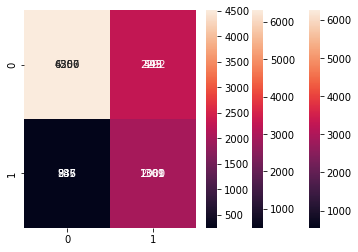

In [31]:
# Import more libraries
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Choices of the three models
# choice = [RFmodel, LRmodel, NBmodel]
choice = [default_RFmodel, default_LRmodel, default_NBmodel]

# Goes through each of the choices and plots their performance metrics
for i in range(3):
    choice[i].fit(X_train, y_train.ravel())
    test_data_predictions = cross_val_predict(choice[i], X_test, y_test.ravel(), cv=20)
    print(choice[i])
    print("Accuracy: " + str(round(accuracy_score(y_test, test_data_predictions),3)))
    
    print("Confusion matrix: ")
    print(confusion_matrix(y_test, test_data_predictions))
    classes_names = ['class 1','class 2','class 3', 'class 4']
    cm = pd.DataFrame(confusion_matrix(y_test, test_data_predictions))
    print(sns.heatmap(cm, annot=True, fmt='d'))
    print(classification_report(y_test, test_data_predictions))
    
    print("F1 score: " + str(round(f1_score(y_test, test_data_predictions)*100,1))+"%")    
    print("Area Under Curve (AUC): " + str(round(roc_auc_score(y_test, test_data_predictions),3)))
    
    print("Precision: " + str(round(precision_score(y_test, test_data_predictions)*100,1))+"%")
    print("Recall: " + str(round(recall_score(y_test, test_data_predictions)*100,1))+"%")
    
    print(" ")

In [32]:
RFmodel 
# 0.8591646626309534
# 0.8601437258153676

LRmodel
# 0.8440722005694226
# 0.8467661691542289

NBmodel
# 0.8298089946651187
# 0.8318407960199005

GaussianNB(var_smoothing=0.001873817422860383)

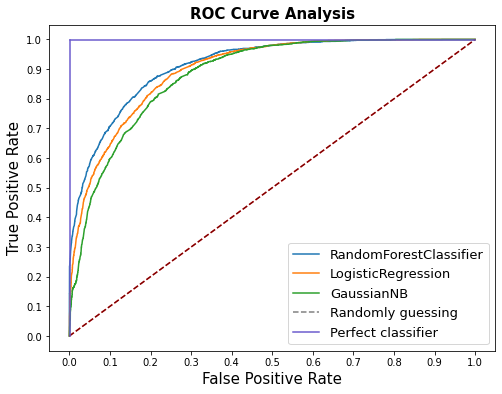

In [33]:
# importing more libraries
from sklearn.metrics import roc_curve, roc_auc_score

# List of all three algorithms
classifiers = [RFmodel, LRmodel, NBmodel]

result_table = pd.DataFrame(columns=['classifiers', 'falsepos','truepos','auc'])

# Form a table of performance metrics for each algorithm
for algorithm in classifiers:
    model = algorithm.fit(X_train, y_train.ravel())
    yprobability = model.predict_proba(X_test)[::,1]
    
    falsepos, truepos, _ = roc_curve(y_test,  yprobability)
    
#     Put all the results in a table for each algorithm
    result_table = result_table.append({'classifiers':algorithm.__class__.__name__,
                                        'falsepos':falsepos, 
                                        'truepos':truepos}, ignore_index=True)    

# Set name of the classifiers as labels
result_table.set_index('classifiers', inplace=True)

# Plot graph
fig = plt.figure(figsize=(8,6))

# For each algorithm, plot the results on the graph to form the ROC curve
for n in result_table.index:
    plt.plot(result_table.loc[n]['falsepos'], 
             result_table.loc[n]['truepos'], 
             label="{}".format(n))
    
plt.plot([0,1], [0,1], color='red', linestyle='--')

# Plot random guess classifier
plt.plot([0,1], [0,1], "k--", alpha=0.5, label="Randomly guessing") 

# Plot perfect classifier
plt.plot([0.002,0.002], [0,0.998], "slateblue", label="Perfect classifier")
plt.plot([0.001,1], [0.998,0.998], "slateblue")

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()



In [34]:
# Compare Algorithms

# prepare models
models = []
models.append((RandomForestClassifier(n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features='auto', max_depth=20, bootstrap=True)))
models.append((GaussianNB(var_smoothing=0.001873817422860383)))
models.append((LogisticRegression(C =  0.1, penalty =  'l2', solver =  'liblinear')))

# evaluate each model
finalresults = []
names = ['LR', 'RF', 'NB']
scoring = 'accuracy'

# Getting mean and std of accuracy for each model
for model in models:
    themodel = model.fit(X_train, y_train.ravel())
    results = cross_val_score(themodel, X_test, y_test.ravel(), cv=20)
    finalresults.append(results)
#     names.append(name)
#     msg = "%s: %f (%f)" % (name, results.mean(), results.std())
#     print(msg)

#Adding in final LR model with {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'} parameters generated from seperate file



# boxplot of accuracy against models
fig = plt.figure()
fig.suptitle('Box Plot Analysis', fontweight='bold')
ax = fig.add_subplot(111)
plt.boxplot(finalresults)
ax.set_xticklabels(names)
plt.ylabel("Accuracy")

plt.show()

AttributeError: 'GaussianNB' object has no attribute 'append'

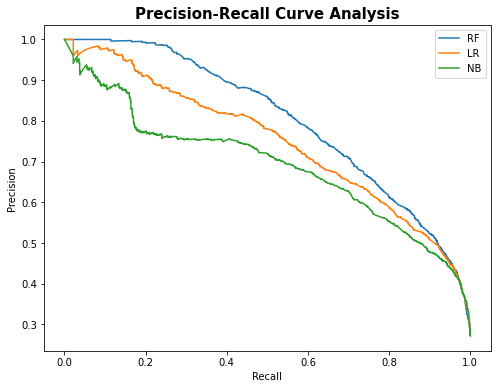

In [ ]:
# Import libraries
from sklearn.datasets import make_classification
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot

# prepare models
model1 = RandomForestClassifier(n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features='auto', max_depth=20, bootstrap=True)
model2 = GaussianNB(var_smoothing=0.001873817422860383)
model3 = LogisticRegression(C=0.1, max_iter=4000, penalty='l2', solver='liblinear')

# Fit model against train data
model1.fit(X_train, y_train.ravel())
model2.fit(X_train, y_train.ravel())
model3.fit(X_train, y_train.ravel())

# predict probabilities
probs1 = model1.predict_proba(X_test)
probs2 = model2.predict_proba(X_test)
probs3 = model3.predict_proba(X_test)

# keep probs with positive outcome only
probs1 = probs1[:, 1]
probs2 = probs2[:, 1]
probs3 = probs3[:, 1]

# Find precision and recall values for each model
precision1, recall1, _ = precision_recall_curve(y_test, probs1)
precision2, recall2, _ = precision_recall_curve(y_test, probs2)
precision3, recall3, _ = precision_recall_curve(y_test, probs3)

# Plot curve for each model 
fig = plt.figure(figsize=(8,6))
pyplot.plot(recall1, precision1, label='RF')
pyplot.plot(recall3, precision3, label='LR')
pyplot.plot(recall2, precision2, label='NB')


plt.title('Precision-Recall Curve Analysis', fontweight='bold', fontsize=15)

# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')

pyplot.legend()
pyplot.show()

In [ ]:
LR_prob = (LogisticRegression(C=0.1, max_iter=4000, penalty='l2', solver='liblinear')).fit(X_train, y_train.ravel()).predict_proba(X_test)
RF_prob = (RandomForestClassifier(n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features='auto', max_depth=20, bootstrap=True)).fit(X_train, y_train.ravel()).predict_proba(X_test)
NB_prob = (GaussianNB(var_smoothing=0.001873817422860383)).fit(X_train, y_train.ravel()).predict_proba(X_test)

probas_list = [RF_prob, LR_prob, NB_prob]
clf_names = ['Random Forest', 'Logistic Regression', 'Gaussian Naive Bayes']

Text(0.5, 1.0, 'Calibration Plot Analysis')

<Figure size 432x288 with 0 Axes>

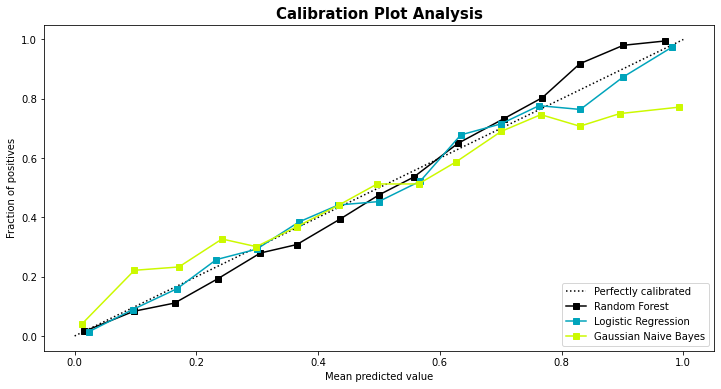

In [ ]:
import scikitplot as skplt

fig = plt.figure()

skplt.metrics.plot_calibration_curve(y_test.ravel(),
                                     probas_list,
                                     clf_names, n_bins=15,
                                     figsize=(12,6)
                                     );

plt.title('Calibration Plot Analysis', fontweight='bold', fontsize=15)

# Need to do pip install scikit-plot !!!!

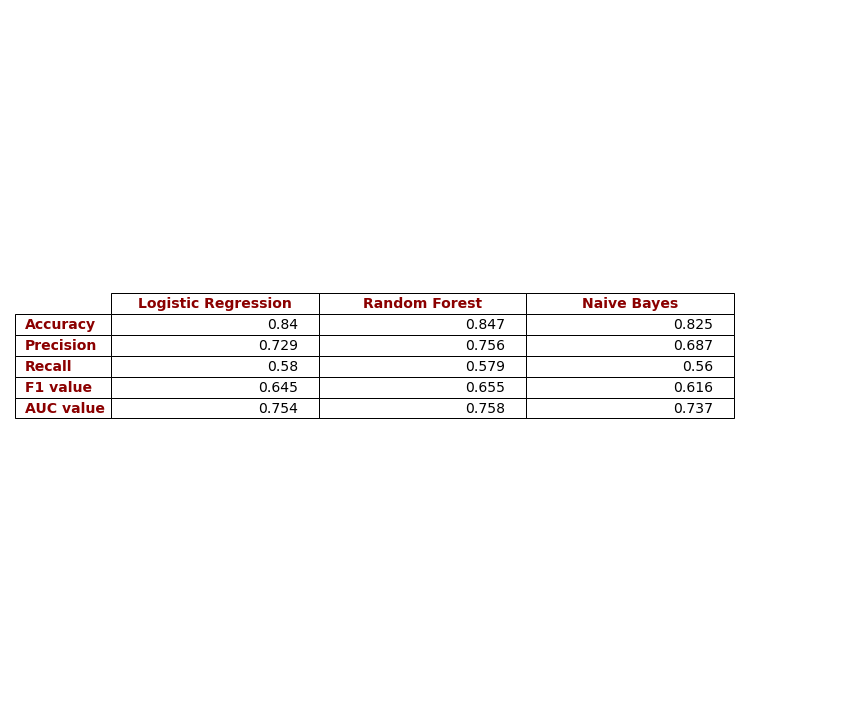

In [ ]:
import matplotlib.pyplot as plt

# Create a table with specific values
values = [[0.840, 0.847, 0.825], [0.729, 0.756, 0.687], [0.580, 0.579, 0.560],[0.645, 0.655, 0.616],[0.754, 0.758, 0.737]]
col_labels = ['Logistic Regression', 'Random Forest', 'Naive Bayes']
row_labels = ['Accuracy', 'Precision', 'Recall', 'F1 value', 'AUC value']

# Create a new figure and axes
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the table
table = ax.table(cellText=values, colLabels=col_labels, rowLabels=row_labels, loc='center')

# Set the fontweight of the headers to bold
for key, cell in table.get_celld().items():
    if key[0] == 0:
        cell.set_text_props(weight='bold')
        cell.set_text_props(color='darkred')

# Set the fontweight of the headers to bold
for key, cell in table.get_celld().items():
    if key[1] == -1:
        cell.set_text_props(weight='bold')
        cell.set_text_props(color='darkred')

# Increase the font size of the text
table.auto_set_font_size(False)
table.set_fontsize(14)

# Increase the width and height of the cells
for key, cell in table.get_celld().items():
    cell.set_height(0.03)
    cell.set_width(0.25)
        
        
# Remove the ticks and labels
ax.axis('tight')
ax.axis('off')

# Display the plot
plt.show()

In [ ]:
RF, LR, NB

    print(np.mean(results['test_accuracy']))
    print(np.mean(results['test_precision']))
    print(np.mean(results['test_recall']))
    print(np.mean(results['test_f1_score']))
    print(np.mean(results['test_AUC']))
    print(" ")

    
RF 
0.847
0.756
0.579
0.655
0.758
 
LR
0.840
0.729
0.580
0.645
0.754
 
NB
0.825
0.687
0.560
0.616
0.737